In [1]:
import os
from pathlib import Path
from google.colab import drive

In [2]:
drive.mount("/content/drive")

Mounted at /content/drive


## 0. Setup Paths - Config - install Object detection


In [3]:
project_dir = "plate-recognition"
BASE_DIR = Path(Path.cwd(), "drive/MyDrive/BlueLabs-AI/Desarrollo/research-env", project_dir)

In [4]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [5]:
paths = {
    'WORKSPACE_PATH': Path(BASE_DIR, 'workspace'),
    'SCRIPTS_PATH': Path(BASE_DIR,'scripts'),
    'APIMODEL_PATH': Path(BASE_DIR,'models'),
    'ANNOTATION_PATH': Path(BASE_DIR, 'workspace','annotations'),
    'IMAGE_PATH': Path(BASE_DIR, 'workspace','images'),
    'MODEL_PATH': Path(BASE_DIR, 'workspace','models'),
    'PRETRAINED_MODEL_PATH': Path(BASE_DIR, 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': Path(BASE_DIR, 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': Path(BASE_DIR, 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':Path(BASE_DIR, 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':Path(BASE_DIR, 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':Path(BASE_DIR,'protoc')
 }

In [6]:
files = {
    'PIPELINE_CONFIG': Path(BASE_DIR, 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': Path(BASE_DIR, "utils", TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': Path(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

## 1. Load train model from checkpoint

In [7]:
import tensorflow as tf
#from object_detection.utils import label_map_util
#from object_detection.utils import visualization_utils as viz_utils

In [8]:
# Prevent GPU complete consumption
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try: 
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RunTimeError as e:
        print(e)


In [9]:
#category_index = label_map_util.create_categories_from_labelmap(files['LABELMAP'])
detect_fn = tf.saved_model.load(str(paths['OUTPUT_PATH'] / "saved_model"))

## 2. Detect from image

In [10]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

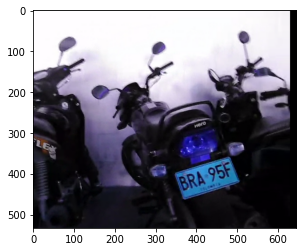

In [12]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'],  'plate_001.png')

img = cv2.imread(IMAGE_PATH)
plt.imshow(img)

In [13]:
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(image_np)
input_tensor = input_tensor[tf.newaxis, ...]
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections
# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

detections.keys()

dict_keys(['detection_classes', 'detection_anchor_indices', 'raw_detection_scores', 'detection_multiclass_scores', 'raw_detection_boxes', 'detection_scores', 'detection_boxes', 'num_detections'])

In [14]:
object_detection_trh = 0.7
cropped_plate = []

image = image_np
scores = list(filter(lambda x: x>object_detection_trh, detections["detection_scores"]))
boxes = detections["detection_boxes"][:len(scores)]
classes = detections["detection_classes"][:len(scores)]

width = image.shape[1]
height = image.shape[0]

for idx, box in enumerate(boxes):
  roi = box*[height, width, height, width]
  cropped_plate.append(image[int(roi[0]): int(roi[2]), int(roi[1]):int(roi[3])])


In [15]:
len(cropped_plate)

1

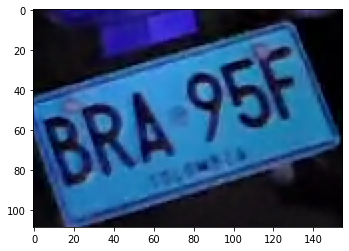

In [17]:
plt.imshow(cropped_plate[0])

## 3. Apply OCR - easyocr

In [ ]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
!pip install easyocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import easyocr
import re

In [ ]:
def filter_text(region, ocr_result, region_threshold):
    rectangle_size = region.shape[0]*region.shape[1]
    
    plate = [] 
    for result in ocr_result:
        length = np.sum(np.subtract(result[0][1], result[0][0]))
        height = np.sum(np.subtract(result[0][2], result[0][1]))
        
        if length*height / rectangle_size > region_threshold:
            plate.append(result[1])
    return plate

TRANSFORM_LASTCHAR = {
    "O": "D",
    "0": "D"
}

def ocr2motorplate(raw_plate):
  plate = re.sub('[^a-zA-Z0-9]', '', raw_plate).upper()

  # check hard rules
  if len(plate) != 6:
    return
  
  last_char = plate[-1]

  last_char_validated = TRANSFORM_LASTCHAR.get(last_char, last_char)
  plate = plate[:-1] + last_char_validated

  return plate



In [ ]:
reader = easyocr.Reader(["en"])

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:253: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will be removed in 0.15. Please access them via the appropriate Weights Enum instead.
  "Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
object_detection_trh = 0.7

image = image_np_with_detections
scores = list(filter(lambda x: x>object_detection_trh, detections["detection_scores"]))
boxes = detections["detection_boxes"][:len(scores)]
classes = detections["detection_classes"][:len(scores)]

In [ ]:
width = image.shape[1]
height = image.shape[0]

[([[2, 6], [217, 6], [217, 82], [2, 82]], '(Ydo 230', 0.4587894574192007)]


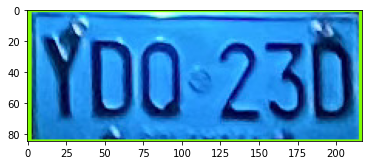

In [ ]:
for idx, box in enumerate(boxes):
  roi = box*[height, width, height, width]
  region = image[int(roi[0]): int(roi[2]), int(roi[1]):int(roi[3])]
  plt.imshow(region)
  ocr_result = reader.readtext(region)
  print(ocr_result)


In [ ]:
def ocr(image, detections, object_detection_trh, region_threshold):
    
    # Scores, boxes and classes above threhold
    scores = list(filter(lambda x: x> object_detection_trh, detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    classes = detections['detection_classes'][:len(scores)]
    
    # Full image dimensions
    width = image.shape[1]
    height = image.shape[0]
    
    # Apply ROI filtering and OCR
    regions = []
    texts = []
    for idx, box in enumerate(boxes):
        roi = box*[height, width, height, width]
        region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        reader = easyocr.Reader(['en'])
        ocr_result = reader.readtext(region)

        text = filter_text(region, ocr_result, region_threshold)
        text = " ".join(text)
        
        texts.append(text)
        regions.append(region)

    return texts, regions

In [ ]:
texts, regions = ocr(image, detections, object_detection_trh, region_threshold)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:253: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will be removed in 0.15. Please access them via the appropriate Weights Enum instead.
  "Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
texts = [ocr2motorplate(raw_plate) for raw_plate in texts]
print(texts)

['YDO23D']


## 3. Apply OCR - tesserac

In [ ]:
! apt install tesseract-ocr
! apt install libtesseract-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 63 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 16s (299 kB/s)
Selecting previously unselecte

In [ ]:
!pip install pytesseract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from PIL import Image
import pytesseract


In [ ]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image, kernel):
    return cv2.medianBlur(image,kernel)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

In [ ]:
plate_detected = region
plate_detected = cv2.cvtColor(plate_detected, cv2.COLOR_BGR2RGB)

In [ ]:
gray = get_grayscale(plate_detected)
gray = remove_noise(gray, 3)
thresh = thresholding(gray)
rgb_img = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)

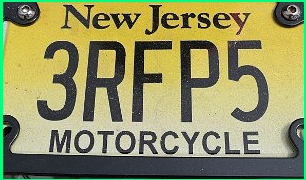

In [ ]:
Image.fromarray(plate_detected)

In [ ]:
a = pytesseract.image_to_string(Image.fromarray(plate_detected), config='--psm 7 tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')

In [ ]:
a.strip()

'SREPS'

## Doctr

In [ ]:
!pip install "python-doctr[torch]"
!pip install 'tensorflow_addons'
!pip install -U Pillow
!pip install pdf2image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 205 kB 4.1 MB/s 
     |████████████████████████████████| 2.8 MB 44.5 MB/s 
     |████████████████████████████████| 101 kB 9.0 MB/s 
     |████████████████████████████████| 235 kB 64.6 MB/s 
     |████████████████████████████████| 604 kB 40.5 MB/s 
     |████████████████████████████████| 88 kB 7.8 MB/s 
     |████████████████████████████████| 2.0 MB 37.2 MB/s 
     |████████████████████████████████| 365 kB 49.1 MB/s 
     |████████████████████████████████| 104 kB 68.4 MB/s 
     |████████████████████████████████| 2.0 MB 48.7 MB/s 
     |████████████████████████████████| 45 kB 4.2 MB/s 
     |████████████████████████████████| 88 kB 8.5 MB/s 
  Created wheel for mplcursors: filename=mplcursors-0.5.1-py3-none-any.whl size=20820 sha256=f61b0402bcc9b3bf289916e5f7e80576d1ddb90d9be0afa34f9da4fe9c26c1ac
  Stored in directory: /root/.cache/pip/wheels/ae/cd/13

In [ ]:
!sudo apt-get install fonts-freefont-ttf -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-freefont-ttf
0 upgraded, 1 newly installed, 0 to remove and 63 not upgraded.
Need to get 4,202 kB of archives.
After this operation, 10.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 fonts-freefont-ttf all 20120503-7 [4,202 kB]
Fetched 4,202 kB in 26s (160 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend

In [ ]:
from doctr.models import ocr_predictor

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [ ]:
def reduce_prediction(doc_1):
  word = []
  box = []
  for block in doc_1['blocks']:
    for line in block['lines']:
      word.append([w['value'].lower() for w in line['words']])
      box.append([b['geometry'] for b in line['words']])
  return word, box

In [ ]:

# model
model = ocr_predictor(
    det_arch='db_resnet50', 
    reco_arch='crnn_vgg16_bn', 
    assume_straight_pages=True,
    pretrained=True
    )

  0%|          | 0/94178964 [00:00<?, ?it/s]

  0%|          | 0/58758994 [00:00<?, ?it/s]

In [ ]:
doc = [rgb_img]

In [ ]:
## predicction
result = model(doc)
json = result.export()
word, box = reduce_prediction(json["pages"][0])

# print the 10 first blocks
word[:10]

[['-'], ['-', '-'], ['-'], ['-'], ['-'], ['-'], ['-'], ['-'], ['-'], ['a1']]

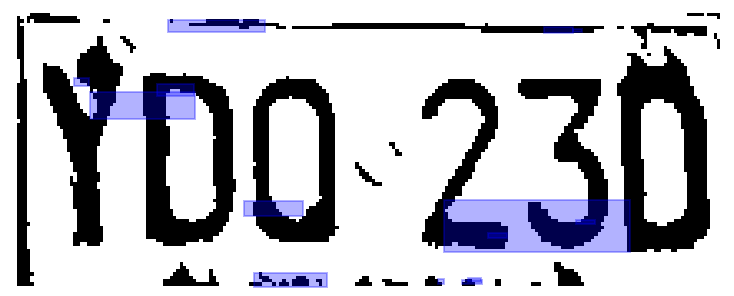

In [ ]:
result.show(doc)

## 3. Apply Paddle

In [20]:
!pip install paddlepaddle -i https://mirror.baidu.com/pypi/simple

Looking in indexes: https://mirror.baidu.com/pypi/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 112.4 MB 62 kB/s 
     |████████████████████████████████| 394 kB 32.9 MB/s 


In [18]:
!pip install paddleocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 334 kB 29.2 MB/s 
     |████████████████████████████████| 604 kB 61.2 MB/s 
     |████████████████████████████████| 55.7 MB 1.2 MB/s 
     |████████████████████████████████| 2.8 MB 58.7 MB/s 
     |████████████████████████████████| 50 kB 6.5 MB/s 
     |████████████████████████████████| 399 kB 56.1 MB/s 
     |████████████████████████████████| 204 kB 71.1 MB/s 
     |████████████████████████████████| 2.3 MB 42.4 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149865 sha256=00030908f4a5c536cd8266546bd71f0a037d00d9002622c18bbccac1087b2a41
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.6.0.

In [21]:
from paddleocr import PaddleOCR

/usr/local/lib/python3.7/dist-packages/yaml/constructor.py:126: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(key, collections.Hashable):


In [22]:
ocr_model = PaddleOCR(use_angle_cls=True, lang='en', show_log = False) # need to run only once to download and load model into memory


download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 3.86M/3.86M [00:05<00:00, 767kiB/s] 


download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv3_rec_infer/en_PP-OCRv3_rec_infer.tar


100%|██████████| 9.96M/9.96M [00:08<00:00, 1.14MiB/s]


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 1.45M/1.45M [00:04<00:00, 357kiB/s]


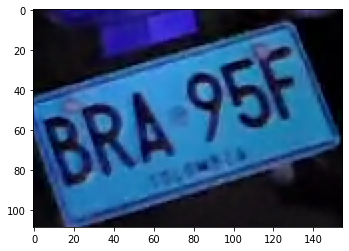

In [23]:
plt.imshow(cropped_plate[0])

In [24]:
plate_text = ocr_model.ocr(cropped_plate[0], cls=False, det=True)

In [25]:
plate_text

[[[[1.0, 53.0], [128.0, 11.0], [140.0, 59.0], [12.0, 100.0]],
  ('BRA-95F', 0.9777256846427917)]]

In [26]:
plate_text[0]

[[[1.0, 53.0], [128.0, 11.0], [140.0, 59.0], [12.0, 100.0]],
 ('BRA-95F', 0.9777256846427917)]

In [27]:
plate_text[0][1]

('BRA-95F', 0.9777256846427917)

In [ ]:
!python3 --version

Python 3.7.13


In [ ]:


# hard rule
TRANSFORM_CHAR = {
    "motorcycle":{
        "last_char":{
            "O": "D",
            "0": "D",
            "4": "A",
            "3": "B"
        },
        "middle_char":{
            "D": "0",
            "A": "4"

        },
        "initial_char":{
            "O": "D",
            "0": "D",
            "4": "A",
            "3": "B"
        }
        
    },
    "car":{
        "last_char":{
            "D": "0",
            "A": "4"
        },
        "initial_char":{
            "O": "D",
            "0": "D",
            "4": "A",
            "3": "B"
        }
    }
}

In [ ]:
transform_chars_motor = TRANSFORM_CHAR["motorcycle"]

In [ ]:
plate_text = "4BC560"

In [ ]:
initian_chars = plate_text[:3]
middle_chars = plate_text[3:5]
last_char = plate_text[-1]

In [ ]:
initian_chars

'4BC'

In [ ]:
def replace_char(chars, transform_dic):
  for s_char, r_char in transform_dic.items():
    chars = chars.replace(s_char, r_char)
  return chars

In [ ]:
initian_chars_r = replace_char(initian_chars, transform_chars_motor["initial_char"])
middle_chars_r = replace_char(middle_chars, transform_chars_motor["middle_char"])
last_char_r = replace_char(last_char, transform_chars_motor["last_char"])

'4BC560'

In [ ]:
initian_chars_r + middle_chars_r + last_char_r

'ABC56D'